In [1]:
from google.colab import drive
import os

# Google Drive 마운트
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# fastdtw 패키지 설치
!pip install fastdtw
!pip install tslearn
!pip install imbalanced-learn  # SMOTE를 사용하기 위해 imbalanced-learn 설치
!pip install dtaidistance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp311-cp311-linux_x86_64.whl size=542088 sha256=56d29b1827d577b969b7fe700b5fdd6162efe7e2ba3fbd96af28b30036ae838d
  Stored in directory: /root/.cache/pip/wheels/5c/8a/f6/fd3df9a9714677410a5ccbf3ca519e66db4a54a1c46ea95332
Successfully built fastdtw
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 28.1 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
from collections import defaultdict
from dtaidistance import dtw
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
from keras.models import Sequential
from keras.layers import LSTM, Dense, Conv1D, Flatten
from scipy.stats import mode
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tslearn.metrics import dtw_path
from fastdtw import fastdtw
from imblearn.metrics import specificity_score

In [4]:
df_X_train = pd.read_csv('/content/drive/My Drive/PhalangesOutlinesCorrect/X_train_sample2.csv')
df_y_train = pd.read_csv('/content/drive/My Drive/PhalangesOutlinesCorrect/y_train_sample2.csv')
df_X_test = pd.read_csv('/content/drive/MyDrive/PhalangesOutlinesCorrect/X_test_sample2.csv')
df_y_test = pd.read_csv('/content/drive/MyDrive/PhalangesOutlinesCorrect/y_test_sample2.csv')

In [5]:
# 데이터 전처리
X_train = df_X_train.values
y_train = df_y_train.values.reshape(-1)  # 1차원 배열(벡터)로 변환
X_test = df_X_test.values
y_test = df_y_test.values.reshape(-1)  # 1차원 배열(벡터)로 변환

# 소수 클래스와 다수 클래스 식별
target_counts = pd.Series(y_train).value_counts()
minority_class = target_counts.idxmin()
majority_class = target_counts.idxmax()

# 소수 클래스 샘플 추출
X_minority = X_train[y_train == minority_class]
X_major = X_train[y_train == majority_class]

In [6]:
from collections import defaultdict
from dtaidistance import dtw

# DTW 기반 데이터 증강 함수
def generate_dtw_synthetic_data(X, num_samples):
    synthetic_data = []

    for _ in range(num_samples):
        # 두 개의 랜덤 시계열 선택
        idx1, idx2 = np.random.choice(len(X), 2, replace=False)
        a, b = X[idx1], X[idx2]

        # DTW Warping Path 계산
        path = dtw.warping_path(a, b)

        # a 시계열 기준 매칭된 b 값 평균 계산
        a_to_b_map = defaultdict(list)
        for i, j in path:
            a_to_b_map[i].append(b[j])

        a_mapped_values = []
        for i in range(len(a)):
            if i in a_to_b_map:
                avg_list = [(a[i] + b_j) / 2 for b_j in a_to_b_map[i]]
                final_avg = np.mean(avg_list)  # 평균들의 평균
            else:
                final_avg = a[i]
            a_mapped_values.append(final_avg)

        # b 시계열 기준 매칭된 a 값 평균 계산
        b_to_a_map = defaultdict(list)
        for i, j in path:
            b_to_a_map[j].append(a[i])

        b_mapped_values = []
        for j in range(len(b)):
            if j in b_to_a_map:
                avg_list = [(b[j] + a_i) / 2 for a_i in b_to_a_map[j]]
                final_avg = np.mean(avg_list)  # 평균들의 평균
            else:
                final_avg = b[j]
            b_mapped_values.append(final_avg)

        # 최종 증강 데이터: a 기반 평균과 b 기반 평균을 다시 평균화
        dtw_augmented = np.mean([a_mapped_values, b_mapped_values], axis=0)
        synthetic_data.append(dtw_augmented)

    return np.array(synthetic_data)

# 증강할 샘플 개수 설정
nCnt = len(X_train) - len(X_minority)

# DTW 기반 증강 데이터 생성
X_aug = generate_dtw_synthetic_data(X_minority, num_samples=nCnt)
y_aug = np.full(len(X_aug), minority_class)


# 원본 데이터와 합성 데이터 결합
X_synthetic = np.concatenate((X_train, X_aug), axis=0)
y_synthetic = np.concatenate((y_train, y_aug), axis=0)

In [8]:
# 예측 함수 정의

# 예측 함수 정의 (최적 모델 및 임계값 사용)
def predict_with_best_rf(X_test):
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    return (y_pred_proba >= best_threshold).astype(int)

def predict_with_logistic_regression(X_train, y_train, X_test):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    return model.predict(X_test)

def predict_with_cart(X_train, y_train, X_test):
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)
    return model.predict(X_test)

def predict_with_knn(X_train, y_train, X_test, k=3):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    return model.predict(X_test)

def predict_with_xgboost(X_train, y_train, X_test):
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)
    return model.predict(X_test)

def predict_with_lstm(X_train, y_train, X_test):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, verbose=0)
    return (model.predict(X_test_reshaped) > 0.5).astype(int)

def predict_with_cnn(X_train, y_train, X_test):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, verbose=0)
    return (model.predict(X_test_reshaped) > 0.5).astype(int)

In [9]:
# Define predictions dictionary
predictions = {
    "Logistic Regression": predict_with_logistic_regression(X_synthetic, y_synthetic, X_test),
    "CART": predict_with_cart(X_synthetic, y_synthetic, X_test),
    "KNN": predict_with_knn(X_synthetic, y_synthetic, X_test),
    "XGBoost": predict_with_xgboost(X_synthetic, y_synthetic, X_test),
    "LSTM": predict_with_lstm(X_synthetic, y_synthetic, X_test),
    "CNN": predict_with_cnn(X_synthetic, y_synthetic, X_test)
}

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:28:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Logistic Regression 모델 성능:
정확도: 0.6353, F1: 0.7520, Recall: 0.8704, Specificity: 0.2258
Confusion Matrix:
[[ 7 24]
 [ 7 47]]


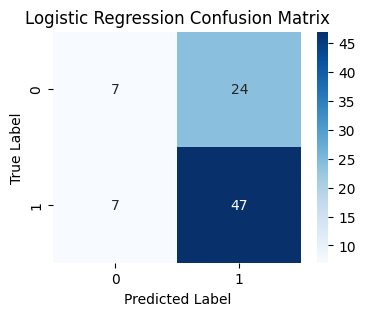

CART 모델 성능:
정확도: 0.6235, F1: 0.7538, Recall: 0.9074, Specificity: 0.1290
Confusion Matrix:
[[ 4 27]
 [ 5 49]]


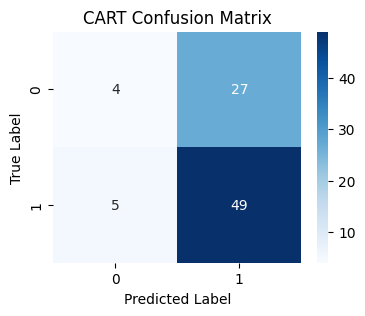

KNN 모델 성능:
정확도: 0.6941, F1: 0.7797, Recall: 0.8519, Specificity: 0.4194
Confusion Matrix:
[[13 18]
 [ 8 46]]


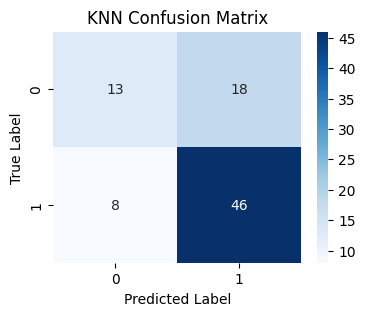

XGBoost 모델 성능:
정확도: 0.6353, F1: 0.7737, Recall: 0.9815, Specificity: 0.0323
Confusion Matrix:
[[ 1 30]
 [ 1 53]]


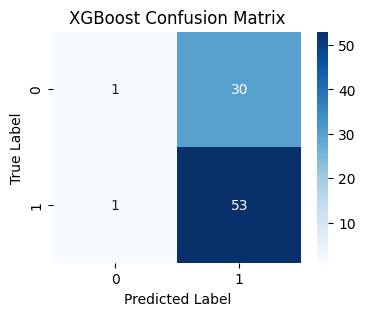

LSTM 모델 성능:
정확도: 0.5765, F1: 0.6250, Recall: 0.5556, Specificity: 0.6129
Confusion Matrix:
[[19 12]
 [24 30]]


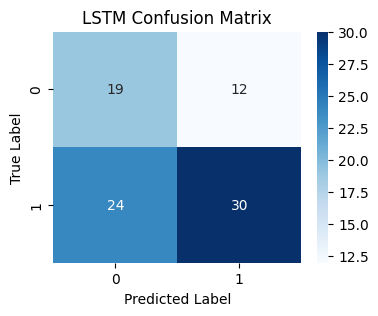

CNN 모델 성능:
정확도: 0.6118, F1: 0.7027, Recall: 0.7222, Specificity: 0.4194
Confusion Matrix:
[[13 18]
 [15 39]]


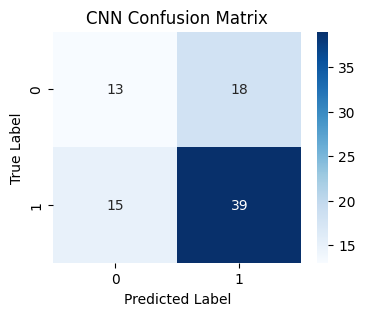

In [10]:
# 성능 지표 저장을 위한 리스트
results = []
for model_name, pred_y in predictions.items():
    accuracy = accuracy_score(y_test, pred_y)
    recall = recall_score(y_test, pred_y)
    f1 = f1_score(y_test, pred_y)
    specificity = specificity_score(y_test, pred_y)
    conf_matrix = confusion_matrix(y_test, pred_y)
    results.append([accuracy, f1, recall, specificity, conf_matrix])
    print(f"{model_name} 모델 성능:")
    print(f"정확도: {accuracy:.4f}, F1: {f1:.4f}, Recall: {recall:.4f}, Specificity: {specificity:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

In [11]:
# 성능 지표를 DataFrame으로 변환
results_df = pd.DataFrame(results, columns=["Accuracy", "F1", "Recall", "Specificity", "Confusion Matrix"], index=predictions.keys())
model_results = results_df.T
# 결과를 출력
print("\n모델 성능 비교 결과:")
print(model_results)

# 결과를 CSV 파일로 저장
model_results.to_csv("/content/drive/My Drive/PhalangesOutlinesCorrect/results/dtw_tsaug_models_result.csv")


모델 성능 비교 결과:
                 Logistic Regression                CART                  KNN  \
Accuracy                    0.635294            0.623529             0.694118   
F1                             0.752            0.753846             0.779661   
Recall                       0.87037            0.907407             0.851852   
Specificity                 0.225806            0.129032             0.419355   
Confusion Matrix  [[7, 24], [7, 47]]  [[4, 27], [5, 49]]  [[13, 18], [8, 46]]   

                             XGBoost                  LSTM  \
Accuracy                    0.635294              0.576471   
F1                          0.773723                 0.625   
Recall                      0.981481              0.555556   
Specificity                 0.032258              0.612903   
Confusion Matrix  [[1, 30], [1, 53]]  [[19, 12], [24, 30]]   

                                   CNN  
Accuracy                      0.611765  
F1                            0.702703  
Rec